In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import pickle
import itertools
import matplotlib
import matplotlib.pyplot as plt
import ete3 as ete
from pylab import *
from scipy import cluster
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor

In [2]:
clusterColorFile = "/Genomics/chanlab/mchan/Adriano/TLS/TLS_TLSCL/20211102_clusterColorsTLSCL.p"
with open(clusterColorFile,'rb') as fp:
    colorDict = pickle.load(fp)

In [3]:
# Load the TLS1 tree
treeFile = "/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/AM-DNA-097_hybrid_newick_noMutationlessEdges_Labeled.nwk"
t = ete.Tree(treeFile,format=1)

In [4]:
# Make the pairwise distance table
leaves = [leaf.name for leaf in t.get_leaves()]

df_pairwiseTreeDist = pd.DataFrame(index = leaves, columns = leaves)


In [5]:
import itertools

cell_pairs = list(itertools.combinations(leaves, 2))

In [6]:
for index, col in cell_pairs:
    dist = t.get_distance(index, col)
    
    df_pairwiseTreeDist.loc[index, col] = dist
    df_pairwiseTreeDist.loc[col, index] = dist

In [7]:
df_pairwiseTreeDist.to_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/AM-DNA-097_TLS1_neighbor_PairwiseBranchDist.txt', sep = '\t', index=False)

In [8]:
# Load the table of pairwise distances between cells
df_pairwiseTreeDist = pd.read_csv("/Genomics/chanlab/mchan/Adriano/TLS/TLS_1_2/20220721_AM-DNA-097_TLS1_PairwiseBranchDistArgo.txt", index_col = 0, sep = "\t")

s = pd.Series(index = df_pairwiseTreeDist.index, dtype = np.float64)
np.fill_diagonal(df_pairwiseTreeDist.values, s)

In [9]:
# Load the TLS1 cell types
df_cellTypes = pd.read_csv('/Genomics/chanlab/blaw/TLS/LineageTracer/scRNAseq/TLS_120h_1_cellBC_cellState.tsv', sep = "\t")

df_cellTypes.set_index("cellBC", inplace = True)
df_cellTypes = df_cellTypes.loc[df_pairwiseTreeDist.index]

In [10]:
leafNames = [n.name for n in t.get_leaves()]

In [11]:
# Group all the early somite cells into an 'EarlySomite' cell type
df_cellTypes.replace(['Somite0','Somite','Somite-1','aPSM','pPSM'], 'EarlySomite', inplace = True)

In [12]:
# merge the distances dataframe with the cell types
df_branchDist = pd.concat([df_pairwiseTreeDist, df_cellTypes.loc[df_pairwiseTreeDist.index, "cell_state"]], axis = 1)

In [13]:
cellTypes = df_cellTypes["cell_state"].unique()
df_minBranchDist = pd.DataFrame(index = cellTypes, columns = df_branchDist.index)
df_minBranchDist.fillna(-1, inplace = True)

for cType in cellTypes:
    cellList = df_cellTypes[df_cellTypes["cell_state"] == cType].index.tolist()
    x1 = df_branchDist.groupby(["cell_state"]).agg(dict.fromkeys(cellList, min))
    df_minBranchDist.loc[cellTypes, cellList] = x1

/tmp/ipykernel_263101/445837340.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_minBranchDist.loc[cellTypes, cellList] = x1
/tmp/ipykernel_263101/445837340.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_minBranchDist.loc[cellTypes, cellList] = x1
/tmp/ipykernel_263101/445837340.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `

In [12]:
# Save the minBranch distances table
df_minBranchDist.to_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/AM-DNA-097_minDist_Table_EarlySomite.txt', sep = '\t')

In [14]:
def create_medianMinBranchTable(df_minBranchDist):
    '''
    input:
        A dataframe of the min branch distance between each cell to cell state comparision
    output:
        A dataframe that contains the median distances for each cell state to cell state comparision
    '''
    df_minBranchDist_t1 = df_minBranchDist.T
    x1 = ["target_" + i for i in df_minBranchDist_t1.columns.tolist()]
    df_minBranchDist_t1.rename(columns = dict(zip(df_minBranchDist_t1.columns, x1)), inplace = True)

    df_minBranchDist_t1 = pd.concat([df_minBranchDist_t1, df_cellTypes.loc[df_minBranchDist_t1.index, "cell_state"]], axis=1)

    x1 = ["target_" + i for i in cellTypes]
    df_cellTypeMinBranchDistMedian = df_minBranchDist_t1.groupby(["cell_state"]).agg(dict.fromkeys(x1, median))
    return df_cellTypeMinBranchDistMedian

In [15]:
# Create the median table for minBranch distances of each cell type to cell type
df_cellTypeMinBranchDistMedian = create_medianMinBranchTable(df_minBranchDist)

### Plot the distributions per cell type pair

In [16]:
cellTypes = ['NMPs', 'NeuralTube1', 'NeuralTube2','EarlySomite', 'SomiteDermo', 'SomiteSclero',
             'Endothelial','Endoderm', 'PCGLC','Unknown']

In [17]:
# column focused
h, axs = plt.subplots(10, 10, figsize = (15, 13))

for i in np.arange(len(cellTypes)):
    for j in np.arange(len(cellTypes)):
        cellList = df_cellTypes[df_cellTypes["cell_state"] == cellTypes[j]].index.tolist()
        axs[j,i].hist(df_minBranchDist.loc[cellTypes[i], cellList], bins = np.arange(30))
        axs[j,i].set_xlim([0,18])
        if i == 0:
            #axs[i,j].set_title(cellTypes[j],fontsize=6)
            axs[j,i].set_ylabel("{}\nn={}".format(cellTypes[j], len(cellList)), fontsize = 6)
        if j == 0:
            axs[j,i].set_title(cellTypes[i], fontsize=6)
            #axs[i,j].set_ylabel("{}\nn={}".format(cellTypes[i],len(cellList)),fontsize=6)
        axs[j,i].tick_params(labelsize = 5)


plt.suptitle('AM-DNA-097_TLS1')
    
plt.subplots_adjust(hspace = 0.6, wspace = 0.5)
    
#plt.savefig("/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/minDist_Distributions.pdf", dpi = 300)
#plt.show()
plt.close()

### Plot distribution of NMP cells to other groups

In [18]:
NMP_cells = df_cellTypes[df_cellTypes['cell_state'] == 'NMPs'].index.values

In [19]:
NMP_somite = np.zeros(len(NMP_cells))
NMP_neural = np.zeros(len(NMP_cells))
NMP_early_somite = np.zeros(len(NMP_cells))
NMP_sclero = np.zeros(len(NMP_cells))
NMP_dermo = np.zeros(len(NMP_cells))
NMP_neuraltube1 = np.zeros(len(NMP_cells)) 
NMP_neuraltube2 = np.zeros(len(NMP_cells))
NMP_PGC = np.zeros(len(NMP_cells))

In [20]:
count = 0
for i in NMP_cells:
    NMP_early_somite[count] = df_minBranchDist.loc['EarlySomite'][i]
    NMP_sclero[count] = df_minBranchDist.loc['SomiteSclero'][i]
    NMP_dermo[count] = df_minBranchDist.loc['SomiteDermo'][i]
    NMP_neuraltube1[count] = df_minBranchDist.loc['NeuralTube1'][i]
    NMP_neuraltube2[count] = df_minBranchDist.loc['NeuralTube2'][i]
    NMP_PGC[count] = df_minBranchDist.loc['PCGLC'][i]
    NMP_somite[count] = min(df_minBranchDist.loc['EarlySomite'][i], df_minBranchDist.loc['SomiteSclero'][i], df_minBranchDist.loc['SomiteDermo'][i])
    NMP_neural[count] = min(df_minBranchDist.loc['NeuralTube1'][i], df_minBranchDist.loc['NeuralTube2'][i])

    count += 1

In [21]:
# Plot the distribution of the distances from an NMP to the closest somite, neural, or PGC cell state
plt.boxplot([NMP_somite, NMP_neural, NMP_PGC],
            labels = ['Somite', 'Neural', 'PGC'])
plt.ylim(0, 15)
plt.tight_layout()
#plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/AM-DNA-097_NMP_minDists.pdf', dpi = 300)
#plt.show()
plt.close()

### Plot distribution of Endothelial cells to other groups

In [22]:
Endothelial_cells = df_cellTypes[df_cellTypes['cell_state'] == 'Endothelial'].index.values

In [23]:
E_early_somite = np.zeros(len(Endothelial_cells))
E_sclero = np.zeros(len(Endothelial_cells))
E_dermo = np.zeros(len(Endothelial_cells))
E_PGC = np.zeros(len(Endothelial_cells))

In [24]:
count = 0
for i in Endothelial_cells:
    E_early_somite[count] = df_minBranchDist.loc['EarlySomite'][i]
    E_sclero[count] = df_minBranchDist.loc['SomiteSclero'][i]
    E_dermo[count] = df_minBranchDist.loc['SomiteDermo'][i]
    E_PGC[count] = df_minBranchDist.loc['PCGLC'][i]
    count += 1

In [28]:
# Plot the distribution of the distances from an NMP to the closest somite, neural, or PGC cell state
plt.boxplot([E_early_somite, E_sclero, E_dermo, E_PGC],
            labels = ['EarlySomite', 'Sclero', 'Dermo', 'PGC'])
plt.ylim(0, 15)
plt.tight_layout()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/AM-DNA-097_Endothelial_minDists.pdf', dpi = 300)
#plt.show()
plt.close()

### Plot the heatmaps

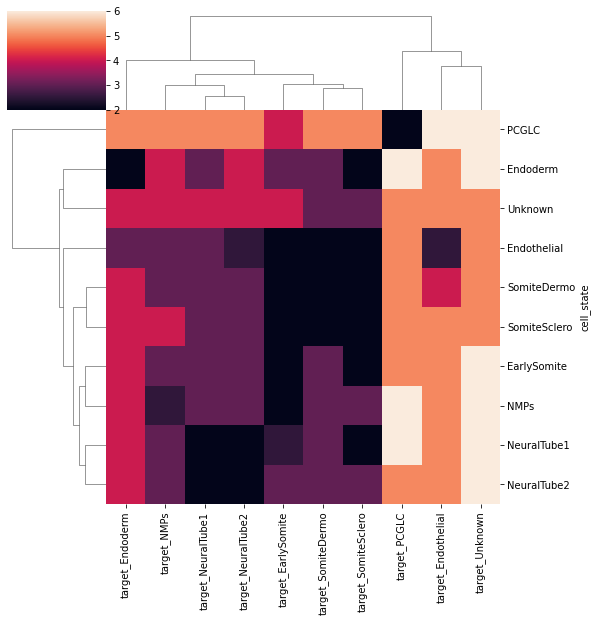

In [18]:
# Plot a clustermap of the median distances between cell states
temp = df_cellTypeMinBranchDistMedian.copy()
#temp.drop(index = ['Unknown'], inplace = True)
g = sns.clustermap(temp)
plt.subplots_adjust(bottom = 0.3, right = 0.7)
#plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/AM-DNA-097_Evolutionary_Coupling.pdf', dpi = 300)
plt.show()
plt.close()